In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
import datetime as dt
import os
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score

In [6]:
def show_one_day_image (tensor):
    plt.imshow (tensor, cmap=plt.cm.afmhot_r)
    plt.colorbar()


### посмотрим что мы имеем

In [7]:
data = pd.read_csv('earthquakes_data.csv', sep=',')
data

,year,month,date,hour,minute,seconds,lat,long,depth,class
0,1990,1,1,2,19,5.018,42.2734,144.8460,8.0,2.9
1,1990,1,1,4,4,20.026,39.9358,142.5461,30.6,3.0
2,1990,1,1,7,14,11.038,36.7053,141.2990,18.6,2.7
3,1990,1,1,9,3,12.039,36.4859,140.6964,67.2,4.3
4,1990,1,1,12,31,25.018,35.0121,138.1440,22.6,2.5
5,1990,1,1,18,2,34.067,35.1802,136.5092,11.0,2.5
6,1990,1,1,23,52,50.070,39.8000,143.7200,0.0,3.0
7,1990,1,2,6,53,12.093,35.5828,141.2393,24.7,2.9
8,1990,1,2,9,43,46.029,42.2963,142.3826,25.1,3.0
9,1990,1,2,10,4,50.086,39.6835,142.9171,34.0,3.4


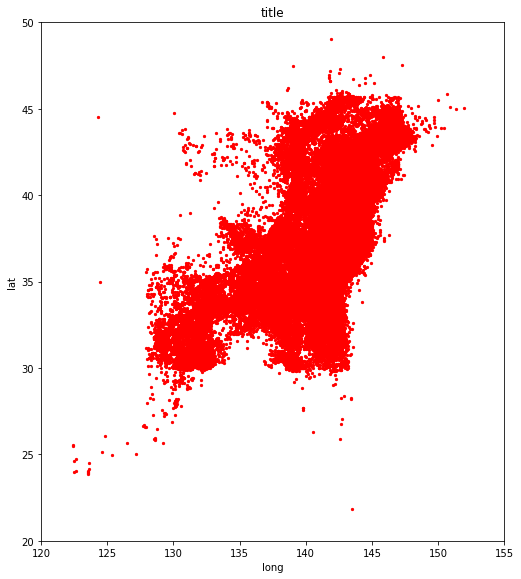

In [8]:
fig = plt.figure(figsize=(10.5 * m.cos(40 * m.pi / 180), 9))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.scatter(data['long'], data['lat'], color='red', marker='.', s=20)
plt.axis([120.0, 155.0, 20.0, 50.0])

axes.set_xlabel('long')
axes.set_ylabel('lat')
axes.set_title('title')

plt.show()

### Спроецируем Японию на плоскость

In [9]:
R_polus   = 6356.86
R_ekvator = 6378.20

def local_radius (longitude):
    return m.cos (longitude * m.pi / 180) * (R_ekvator - R_polus) + R_polus

R_japan = local_radius (37)

In [10]:
ORIGIN_LATITUDE  = 27.0
ORIGIN_LONGITUDE = 127.0

def spherical_to_cartesian (longitude, latitude):
    X = (longitude - ORIGIN_LONGITUDE) * m.pi / 180 * R_japan * m.cos (latitude * m.pi / 180)
    Y = (latitude  - ORIGIN_LATITUDE ) * m.pi / 180 * R_japan 
    
    return X, Y

data.shape

(247474, 10)

In [11]:
XY_massive = np.zeros((data.shape[0], 2))
j = 0
for i in tqdm(range (XY_massive.shape[0])):
    XY_massive[i][0], XY_massive[i][1] = spherical_to_cartesian (data['long'][i], data['lat'][i])

data['x'] = XY_massive[:, 0]
data['y'] = XY_massive[:, 1]
#data['lat'], data['long'] = spherical_to_cartesian (data['lat'], data['long'])

#### Посмотрим что получилось

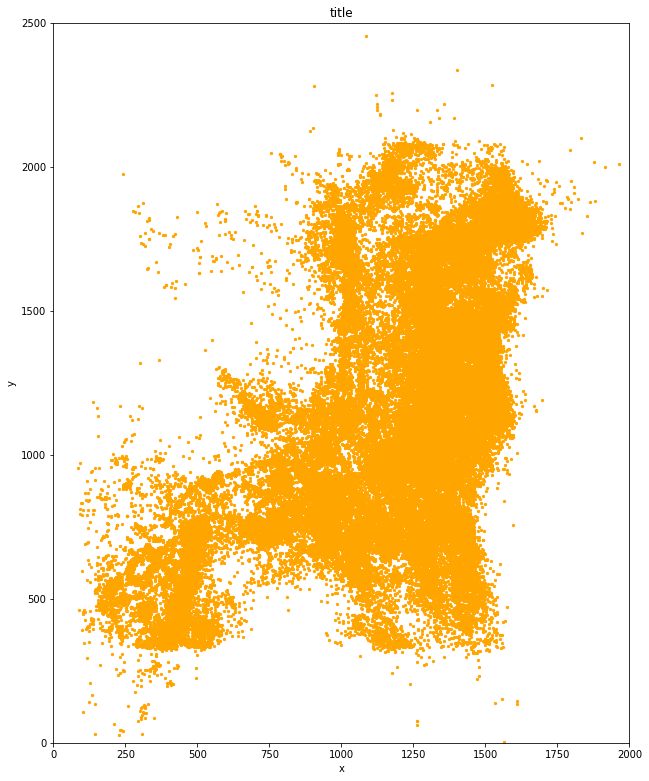

In [12]:
fig = plt.figure(figsize=(10, 12.5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.scatter(data['x'], data['y'], color='orange', marker='.', s=20)
plt.axis([0, 2000, 0, 2500])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('title')

plt.show()

In [13]:
a = np.zeros(20, dtype=int)
for i in tqdm(range (data.shape[0])):
    for threshold in range (20):
        if (data['class'][i] >= threshold/2) and (data['class'][i] < threshold/2 + 0.5):
            a[threshold] += 1
            break

            
# print ((a / data.shape[0] * 100).int())

    

#### Распечатаем сколько землетрясений и с какой амплитудой случалось

In [14]:
for i in range (a.shape[0]):
    print ('from ', i/2, ' to ', i/2+0.5, ' : %.2f' % (a[i]/data.shape[0]*100), '% of dots')

from  0.0  to  0.5  : 0.00 % of dots
from  0.5  to  1.0  : 0.00 % of dots
from  1.0  to  1.5  : 0.00 % of dots
from  1.5  to  2.0  : 0.00 % of dots
from  2.0  to  2.5  : 0.00 % of dots
from  2.5  to  3.0  : 51.02 % of dots
from  3.0  to  3.5  : 29.93 % of dots
from  3.5  to  4.0  : 11.94 % of dots
from  4.0  to  4.5  : 4.49 % of dots
from  4.5  to  5.0  : 1.65 % of dots
from  5.0  to  5.5  : 0.59 % of dots
from  5.5  to  6.0  : 0.23 % of dots
from  6.0  to  6.5  : 0.09 % of dots
from  6.5  to  7.0  : 0.03 % of dots
from  7.0  to  7.5  : 0.01 % of dots
from  7.5  to  8.0  : 0.00 % of dots
from  8.0  to  8.5  : 0.00 % of dots
from  8.5  to  9.0  : 0.00 % of dots
from  9.0  to  9.5  : 0.00 % of dots
from  9.5  to  10.0  : 0.00 % of dots


#### Посчитаем сколько дней прошло с 01.01.1990 до i-го землетрясения

In [15]:
time_massive = np.zeros (data.shape[0])

d_0 = dt.date (data['year'][0], data['month'][0], data['date'][0])
for i in tqdm(range (data.shape[0])):
    d_i = dt.date (data['year'][i], data['month'][i], data['date'][i])
    time_massive[i] = (d_i - d_0).days
    
data['time'] = time_massive

#### Посмотрим что имеем 

In [16]:
data

,year,month,date,hour,minute,seconds,lat,long,depth,class,x,y,time
0,1990,1,1,2,19,5.018,42.2734,144.8460,8.0,2.9,1469.001496,1699.098417,0.0
1,1990,1,1,4,4,20.026,39.9358,142.5461,30.6,3.0,1326.068924,1439.050722,0.0
2,1990,1,1,7,14,11.038,36.7053,141.2990,18.6,2.7,1275.297146,1079.671839,0.0
3,1990,1,1,9,3,12.039,36.4859,140.6964,67.2,4.3,1225.030854,1055.264556,0.0
4,1990,1,1,12,31,25.018,35.0121,138.1440,22.6,2.5,1015.369695,891.310804,0.0
5,1990,1,1,18,2,34.067,35.1802,136.5092,11.0,2.5,864.632781,910.011188,0.0
6,1990,1,1,23,52,50.070,39.8000,143.7200,0.0,3.0,1429.027552,1423.943571,0.0
7,1990,1,2,6,53,12.093,35.5828,141.2393,24.7,2.9,1288.276622,954.798663,1.0
8,1990,1,2,9,43,46.029,42.2963,142.3826,25.1,3.0,1265.765445,1701.645941,1.0
9,1990,1,2,10,4,50.086,39.6835,142.9171,34.0,3.4,1362.707004,1410.983460,1.0


## Разбиение датасета по дням и по клеткам в сетке

In [17]:
LEFT_BORDER = 0
RIGHT_BORDER = 2000
DOWN_BORDER = 0
UP_BORDER = 2500

N_CELLS_HOR = 200
N_CELLS_VER = 250

print (data['time'][data.shape[0] - 1])
celled_data = torch.zeros ([int (data['time'][data.shape[0] - 1] + 1), 1, N_CELLS_HOR, N_CELLS_VER])
print (celled_data.shape)

for i in tqdm(range (data.shape[0])):
    if (data['x'][i] > LEFT_BORDER) and (data['x'][i] < RIGHT_BORDER) and (data['y'][i] > DOWN_BORDER) and (data['y'][i] < UP_BORDER):
        x = int (data['x'][i] / (RIGHT_BORDER - LEFT_BORDER) * N_CELLS_HOR)
        y = int (data['y'][i] / (UP_BORDER    - DOWN_BORDER) * N_CELLS_VER)
        celled_data[int(data['time'][i]), 0, x, y] = data['class'][i]
#         celled_data[int(data['time'][i]), 1, x, y] = data['depth'][i]
        
# celled_data
#del data
        
    


9590.0
torch.Size([9591, 1, 200, 250])


In [18]:
print (celled_data.shape)
print (celled_data.dtype)

torch.Size([9591, 1, 200, 250])
torch.float32


### Создадим с RTL фичи

In [19]:
R_0 = 25
T_0 = 20
T_decay = m.exp(-1/T_0)

In [20]:
days_indicies = torch.zeros ([int (data['time'][data.shape[0] - 1] + 2)], dtype=torch.int)

i = 0
j = 0
# while (i < int (data['time'][data.shape[0] - 1] + 1)):
for i in tqdm(range (int (data['time'][data.shape[0] - 1] + 1))):
    while (data['time'][j] < i):
        j += 1
    days_indicies[i] = j
days_indicies[int (data['time'][data.shape[0] - 1] + 1)] = len(data)
print (days_indicies)



tensor([     0,      7,     20,  ..., 247473, 247473, 247474],
       dtype=torch.int32)


In [21]:
def string_day_nomber(day):
    return (str(int (day/1000)%10) + 
            str(int (day/100)%10) +
            str(int (day/10)%10) +
            str(int (day/1)%10))

### 1) Region

In [22]:
def R_features_each_day_loc ():
    R_features_loc = torch.zeros ([int (data['time'][data.shape[0] - 1] + 1),
                                   N_CELLS_HOR,
                                   N_CELLS_VER])
    
    for t_target in tqdm(range(R_features_loc.shape[0])):
        for i_target in range(R_features_loc.shape[1]):
            for j_target in range(R_features_loc.shape[2]):
                x_target = ((RIGHT_BORDER - LEFT_BORDER) /
                            N_CELLS_HOR *
                            (i_target + 0.5))
                y_target = ((UP_BORDER    - DOWN_BORDER) /
                            N_CELLS_VER *
                            (j_target + 0.5))
                for i in range(days_indicies[t_target], days_indicies[t_target+1]):
                    r_i = pow ((pow((x_target - data['x'][i]), 2) + 
                                pow((y_target - data['y'][i]), 2)),
                               0.5)
                    R_features_loc[t_target, i_target, j_target] += m.exp(-r_i/R_0)
        
    return R_features_loc

def R_features_one_day_loc (day):
    R_features_loc = torch.zeros ([N_CELLS_HOR,N_CELLS_VER])
    
    for i_target in range(R_features_loc.shape[0]):
        for j_target in range(R_features_loc.shape[1]):
            x_target = ((RIGHT_BORDER - LEFT_BORDER) /
                        N_CELLS_HOR *
                        (i_target + 0.5))
            y_target = ((UP_BORDER    - DOWN_BORDER) /
                        N_CELLS_VER *
                        (j_target + 0.5))
            
            for i in range(days_indicies[day], days_indicies[day+1]):
                r_i = pow ((pow((x_target - data['x'][i]), 2) + 
                            pow((y_target - data['y'][i]), 2)),
                           0.5)
                R_features_loc[i_target, j_target] += m.exp(-r_i/R_0)
#     print ("day =", day, "n_earthquakes =", days_indicies[day+1].item() - days_indicies[day].item())
    return R_features_loc

def save_days_loc (r_0, indicies):
    for i in tqdm(indicies):
        torch.save(R_features_one_day_loc(i),
                   "RTL_features/R_" + str(r_0) + "_loc/" + string_day_nomber(i))

In [23]:
# save_days_loc(R_0,
#               range(7835, 8095))

In [24]:
def cat_loc_R_features_in_one(r_0):
    R_features_loc = torch.zeros([0, N_CELLS_HOR, N_CELLS_VER])
    for i in range (int (data['time'][data.shape[0] - 1] + 1)):
        day_map = torch.load("RTL_features/R_" + str(r_0) + "_loc/" + string_day_nomber(i))
        R_features_loc = torch.cat([R_features_loc, day_map.unsqueeze(0)], dim=0)
    print (R_features_loc.shape)
    torch.save(R_features_loc,
               "RTL_features/R_" + str(r_0))

In [25]:
def cat_loc_R_features_in_one():
    R_features_all = torch.zeros([int (data['time'][data.shape[0] - 1] + 1),
                                  N_CELLS_HOR,
                                  N_CELLS_VER])
    print (int (data['time'][data.shape[0] - 1] + 1))
    days_map = torch.zeros([N_CELLS_HOR, N_CELLS_VER])
    for i in tqdm(range (int (data['time'][data.shape[0] - 1] + 1))):
        tom_day_map = torch.load("RTL_features/R_"
                                  + str(R_0)
                                  + "_loc/"
                                  + string_day_nomber(i))
        days_map += tom_day_map
        if (i - T_0 >= 0):
            yest_day_map = torch.load("RTL_features/R_"
                                       + str(R_0)
                                       + "_loc/"
                                       + string_day_nomber(i - T_0))
            days_map -= yest_day_map
        R_features_all[i, :, :] = days_map
    print (R_features_all.shape)
    torch.save(R_features_all,
               "RTL_features/R_R=" + str(R_0) + "_T=" + str(T_0) + "_loc")

In [26]:
# for R_0 in (25, 50, 100):
#     for T_0 in (20, 45, 90):
#         cat_loc_R_features_in_one()

### 2) Time

In [27]:
def T_feature_next_day (prev_day, day, r_0, t_0):
    next_day = prev_day * m.exp(-1/T_0)
    for i_target in range(next_day.shape[0]):
        for j_target in range(next_day.shape[1]):
            x_target = ((RIGHT_BORDER - LEFT_BORDER) /
                        N_CELLS_HOR *
                        (i_target + 0.5))
            y_target = ((UP_BORDER    - DOWN_BORDER) /
                        N_CELLS_VER *
                        (j_target + 0.5))
            for i in range(days_indicies[day], days_indicies[day+1]):
                r_i = pow ((pow((x_target - data['x'][i]), 2) + 
                            pow((y_target - data['y'][i]), 2)),
                            0.5)
                if (r_i < r_0):
                    next_day[i_target, j_target] += 1
    return next_day

def save_T_features (indicies, r_0, t_0):
    directory_name = ("RTL_features/" +
                      "T_" + str(t_0) +
                      "_R_" + str(r_0) +
                      "_loc/")
    for i in tqdm(indicies):
        prev_day = torch.load (directory_name + string_day_nomber(i - 1))
        torch.save (T_feature_next_day(prev_day, i, r_0, t_0),
                    directory_name + string_day_nomber(i))

In [28]:
# torch.save (torch.zeros([N_CELLS_HOR, N_CELLS_VER], dtype=torch.float),
#             "RTL_features/" +
#             "T_" + str(T_0) +
#             "_R_" + str(R_0) +
#             "_loc/" + "0009")

In [29]:
# save_T_features(range(8075, 9591), R_0, T_0)

In [30]:
# show_one_day_image(torch.load("RTL_features/" +
#                               "T_" + str(T_0) +
#                               "_R_" + str(R_0) +
#                               "_loc/" + "0011"))

In [31]:
def cat_loc_T_features_in_one():
    T_features_all = torch.zeros([int (data['time'][data.shape[0] - 1] + 1),
                                  N_CELLS_HOR,
                                  N_CELLS_VER])
    for i in tqdm(range (int (data['time'][data.shape[0] - 1] + 1))):
        day_map = torch.load("RTL_features/T_"
                             + str(T_0)
                             + "_R_"
                             + str(R_0)
                             + "_loc/"
                             + string_day_nomber(i))
        T_features_all[i, :, :] = day_map
    print (T_features_all.shape)
    torch.save(T_features_all,
               "RTL_features/T_R="
               + str(R_0)
               + "_T="
               + str(T_0)
               + "_all")

In [32]:
# for T_0 in (20, 45, 90):
#     for R_0 in (25, 50, 100):
#         cat_loc_T_features_in_one()

### 3) lenght

In [33]:
def L_features_one_day_loc (day):
    L_features_loc = torch.zeros ([N_CELLS_HOR,N_CELLS_VER])
    
    for i_target in range(L_features_loc.shape[0]):
        for j_target in range(L_features_loc.shape[1]):
            x_target = ((RIGHT_BORDER - LEFT_BORDER) /
                        N_CELLS_HOR *
                        (i_target + 0.5))
            y_target = ((UP_BORDER    - DOWN_BORDER) /
                        N_CELLS_VER *
                        (j_target + 0.5))
            
            for i in range(days_indicies[day], days_indicies[day+1]):
                r_i = pow ((pow((x_target - data['x'][i]), 2) + 
                            pow((y_target - data['y'][i]), 2)),
                           0.5)
                if (r_i < R_0):
                    l_i = m.exp (0.5 * data['class'][i] - 1.8)
                    L_features_loc[i_target, j_target] += m.exp(-l_i/R_0)
    print ("day =", day, "n_earthquakes =", days_indicies[day+1].item() - days_indicies[day].item())
    return L_features_loc

def save_L_days_loc (r_0, indicies):
    for i in tqdm(indicies):
        torch.save(L_features_one_day_loc(i),
                   "RTL_features/L_" + str(r_0) + "_loc/" + string_day_nomber(i))

In [34]:
# save_L_days_loc(R_0, range(7924, 8200))

In [35]:
def cat_loc_L_features_in_one():
    L_features_all = torch.zeros([int (data['time'][data.shape[0] - 1] + 1),
                                  N_CELLS_HOR,
                                  N_CELLS_VER])
    print (int (data['time'][data.shape[0] - 1] + 1))
    days_map = torch.zeros([N_CELLS_HOR, N_CELLS_VER])
    for i in tqdm(range (int (data['time'][data.shape[0] - 1] + 1))):
        tom_day_map = torch.load("RTL_features/L_"
                                  + str(R_0)
                                  + "_loc/"
                                  + string_day_nomber(i))
        days_map += tom_day_map
        if (i - T_0 >= 0):
            yest_day_map = torch.load("RTL_features/L_"
                                       + str(R_0)
                                       + "_loc/"
                                       + string_day_nomber(i - T_0))
            days_map -= yest_day_map
        L_features_all[i, :, :] = days_map
    print (L_features_all.shape)
    torch.save(L_features_all,
               "RTL_features/L_R=" + str(R_0) + "_T=" + str(T_0) + "_all")

In [36]:
# for R_0 in (25, 50, 100):
#     for T_0 in (20, 45, 90):
#         cat_loc_L_features_in_one()

In [37]:
def create_RTL(R_range, T_range):
    for r_0 in tqdm(R_range):
        for t_0 in tqdm(T_range):
            R_features = torch.load("RTL_features/R_R="
                                    + str(r_0)
                                    + "_T="
                                    + str(t_0)
                                    + "_all")
            T_features = torch.load("RTL_features/T_R="
                                    + str(r_0)
                                    + "_T="
                                    + str(t_0)
                                    + "_all")
            L_features = torch.load("RTL_features/L_R="
                                    + str(r_0)
                                    + "_T="
                                    + str(t_0)
                                    + "_all")
            RTL_features = R_features * T_features * L_features
            torch.save (RTL_features, 
                        "RTL_features/RTL_R="
                         + str(r_0)
                         + "_T="
                         + str(t_0)
                         + "_all")
            

In [38]:
def cat_all_in_one(R_range, T_range, saving_file):
    RTL_features_all = torch.zeros([int (data['time'][data.shape[0] - 1] + 1),
                                    9,
                                    N_CELLS_HOR,
                                    N_CELLS_VER])
    i = 0
    for r_0 in tqdm(R_range):
        for t_0 in tqdm(T_range):
            RTL_feature = torch.load("RTL_features/RTL_R="
                                     + str(r_0)
                                     + "_T="
                                     + str(t_0)
                                     + "_all")#.unsqueeze(1)
#             RTL_features_all = torch.cat([RTL_features_all, RTL_feature], dim=1)
            RTL_features_all[:, i, :, :] = RTL_feature
            i += 1
    torch.save(RTL_features_all,
               saving_file)

            

In [39]:
# create_RTL(R_range=(25, 50, 100),
#            T_range=(20, 45, 90))

In [40]:
# cat_all_in_one(R_range=(25, 50, 100),
#                T_range=(20, 45, 90),
#                saving_file="Data/RTL_features")

In [ ]:
def compute_RTL_data ():
    RTL_data = torch.zeros ([int (data['time'][data.shape[0] - 1] + 1),
                             3,
                             N_CELLS_HOR,
                             N_CELLS_VER])#.to(DEVICE)

    for t_target in tqdm(range (T_0, RTL_data.shape[0])):
#     for t_target in tqdm(range (T_0, T_0+1)):
        for i_target in range (RTL_data.shape[2]):
            print ('i = ', i_target)
            for j_target in range (RTL_data.shape[3]):
                x_target = (RIGHT_BORDER - LEFT_BORDER) / N_CELLS_HOR * (i_target + 0.5)
                y_target = (UP_BORDER    - DOWN_BORDER) / N_CELLS_VER * (j_target + 0.5)
                for i in range (days_indicies[t_target - T_0], days_indicies[t_target]):
                    r_i = pow ((pow((x_target - data['x'][i]), 2) + 
                                pow((y_target - data['y'][i]), 2)),
                              0.5)
                    t_i = t_target - data['time'][i]
                    l_i = m.exp (0.5 * data['class'][i] - 1.8)
                    RTL_data[t_target, 0, i_target, j_target] += m.exp (- r_i/R_0)
                    RTL_data[t_target, 1, i_target, j_target] += m.exp (- t_i/T_0)
                    RTL_data[t_target, 2, i_target, j_target] += m.exp (l_i/r_i)

            print ('R =',
                   RTL_data[t_target, 0, i_target, 100],
                   'T =',
                   RTL_data[t_target, 1, i_target, 100],
                   'L =',
                   RTL_data[t_target, 2, i_target, 100])

    return RTL_data